<a href="https://colab.research.google.com/github/LambdaLabsML/lambda-diffusers/blob/main/notebooks/pokemon_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokémon text to image

This notebook demonstrates inference using Stable Diffusion fine tuned on Pokémon to generate new Pokémon form text prompts. The model has been ported to Huggingface Diffusers for easier inference.

For more details about the fine tuning process and how to make your own specialised model see [this guide](https://github.com/LambdaLabsML/examples/tree/main/stable-diffusion-finetuning).

Also see the following links for more info:

- [Lambda Diffusers](https://github.com/LambdaLabsML/lambda-diffusers)
- [Captioned Pokémon dataset](https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions)
- [Model weights in Diffusers format](https://huggingface.co/lambdalabs/sd-pokemon-diffusers)
- [Original model weights](https://huggingface.co/justinpinkney/pokemon-stable-diffusion)
- [Training code](https://github.com/justinpinkney/stable-diffusion)

Created by Justin Pinkney at [Lambda Labs](https://lambdalabs.com/)

In [1]:
!nvidia-smi

Mon Nov 20 15:50:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   40C    P3    10W /  60W |     10MiB /  8188MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# !pip install diffusers==0.3.0
# !pip install transformers scipy ftfy

In [3]:
import torch
from diffusers import StableDiffusionPipeline
from torch import autocast

pipe = StableDiffusionPipeline.from_pretrained("lambdalabs/sd-pokemon-diffusers", torch_dtype=torch.float16)  
pipe = pipe.to("cuda")

/home/owl/.conda/envs/diffusion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
text_encoder/model.safetensors not found
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.
Loading pipeline components...:  29%|██▊       | 2/7 [00:13<00:32,  6.54s/it]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which 

In [4]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

100%|██████████| 50/50 [00:22<00:00,  2.25it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


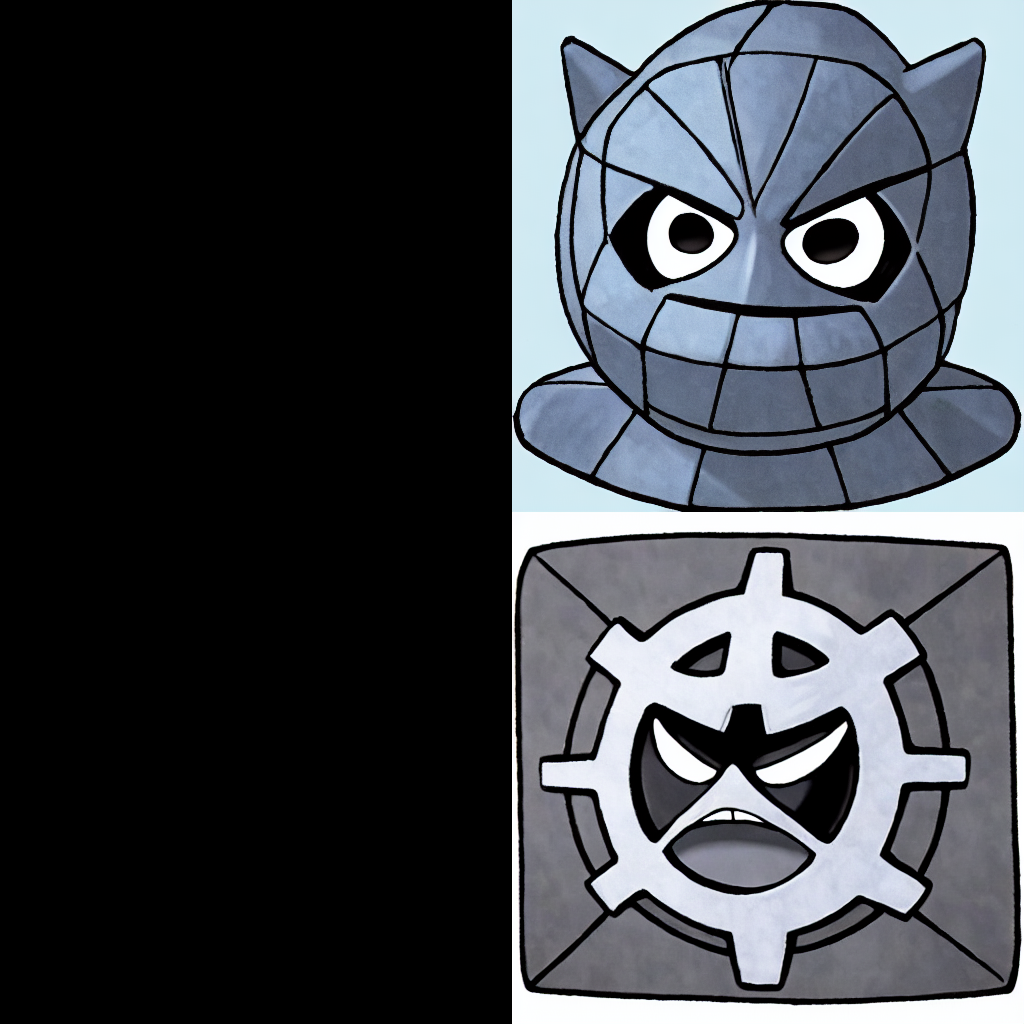

In [5]:
prompt = "cold face"
scale = 10
n_samples = 4

# Sometimes the nsfw checker is confused by the Pokémon images, you can disable
# it at your own risk here
disable_safety = False

if disable_safety:
  def null_safety(images, **kwargs):
      return images, False
  pipe.safety_checker = null_safety

with autocast("cuda"):
  images = pipe(n_samples*[prompt], guidance_scale=scale).images

grid = image_grid(images, rows=2, cols=2)
grid